Read it to understand basic credit risk assessment: https://www.kaggle.com/code/samudra89/01-credit-risk-modeling


https://finbox.in/blog/credit-risk-modelling/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import cv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/PROJECT/Credit Risk Assessment/credit_risk_dataset.csv")
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


In [4]:
# shape of the data
df.shape

(32581, 12)

In [5]:
# type of each column
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [6]:
# unique values of each object column
for col in df.select_dtypes(include=['object']):
    print(col, ":" ,df[col].unique())

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


In [7]:
# check loan grade is ordinal or not?
df.groupby('loan_grade').head(3).reset_index(drop=True).sort_values(by='loan_grade')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10,21,10000,OWN,2.0,HOMEIMPROVEMENT,A,4500,8.63,1,0.45,N,2
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
13,23,113000,RENT,8.0,DEBTCONSOLIDATION,D,35000,18.25,1,0.31,N,4


Data Pre-processing

In [8]:
# check for other missing value percentage
(df.isnull().sum() / len(df)).sort_values(ascending=False) * 100

loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

As you can see there is a significant number of rows with missing values in the 'loan_int_rate' column, accounting for approximately 9.5% of the dataset. Upon running the previous cell, you can see that 3116 rows lack information regarding the loan interest rate. I believe that the loan interest rate is a crucial factor in predicting credit defaults. However, there is insufficient information within the existing dataset to impute these missing values, and the data description offers limited information. Hence, I decided to remove rows with NaN values in the 'loan_int_rate' column. There is still a significant amount of data available even after these removals, allowing us to continue our analysis with a reasonably sized dataset.

In [9]:
# dropping the missing values
df.dropna(inplace=True)

In [10]:
df['person_age'].max()

144

Exploratory Data Analysis

Value counts of 0    22435
1     6203
Name: loan_status, dtype: int64


Text(0.5, 1.0, 'Loan status of Customers')

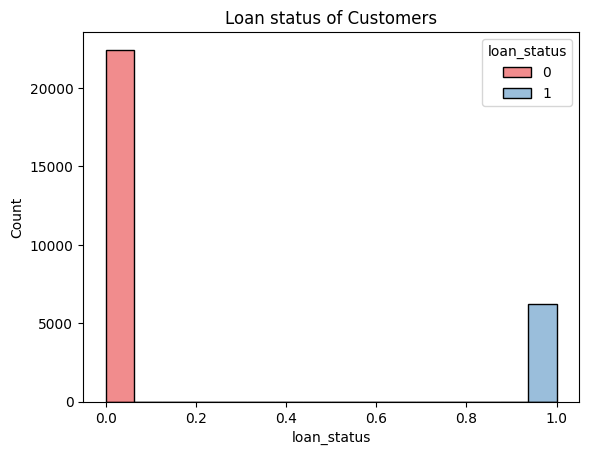

In [11]:
# check the class balance
print("Value counts of", df['loan_status'].value_counts())
sns.histplot(data=df, x="loan_status", hue="loan_status", palette = "Set1")
plt.title('Loan status of Customers')

As one would have expected, in our data there are many instances that customers have no default on file. Only 17% of the data accounts for having defaulted on their files. Let's handle this class imbalance when we train the models.

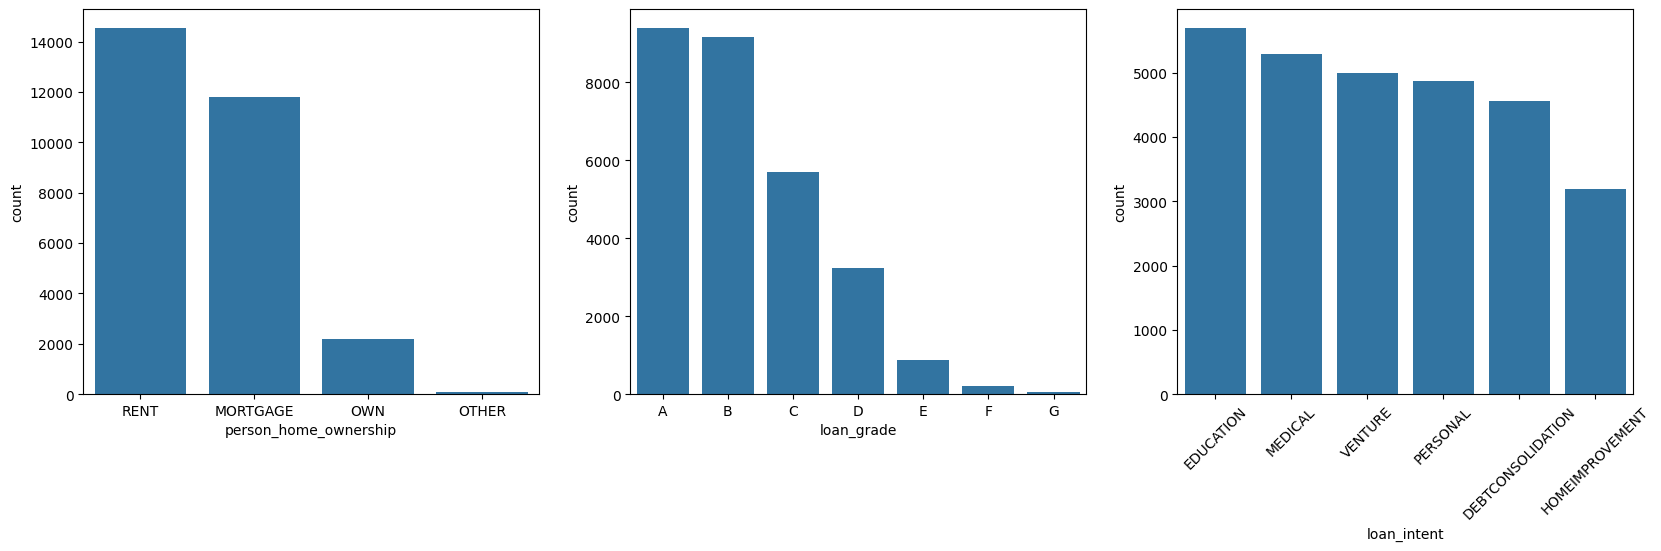

In [12]:
columns = {0:'person_home_ownership', 1: 'loan_grade', 2: 'loan_intent'}
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for key, val in columns.items():
    sns.countplot(x=val,  data=df, ax=ax[key], order = df[val].value_counts().index)
    plt.xticks(rotation=45)

The countplots shows a preliminary glance into the categorical variables within the dataset. A significant proportion of loan applicants do not own a home and instead reside in rental properties. The loan grades largely fall into categories A and B, with G being the least common grade. The loan intent plot is quite interesting, showing that a substantial number of loan applications are associated with educational or medical purposes. Lets' further explore the data with the continus features.

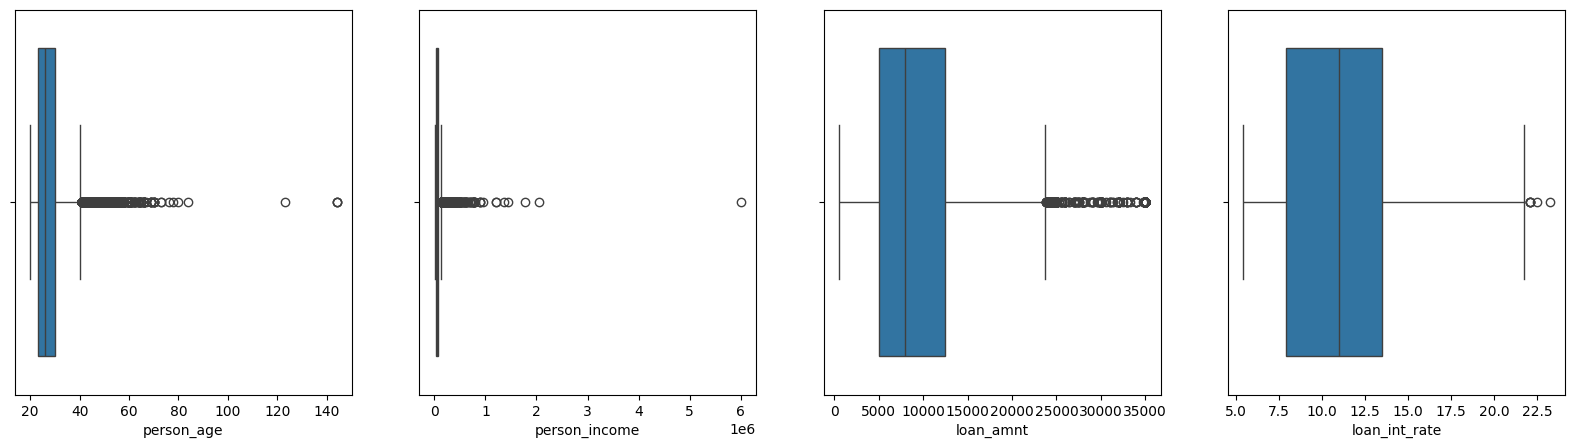

In [13]:
columns = {0:'person_age' , 1: 'person_income', 2: 'loan_amnt', 3:'loan_int_rate'}
fig, ax = plt.subplots(1,len(columns), figsize=(20, 5))
for key, val in columns.items():
    sns.boxplot(x=df[val], ax= ax[key])

There are some outliers in our data, e.g., a person's age is 140, and a income value around 6000000. We will remove these outliers from our data.

In [14]:
# assuming a persons limit is less than 90 years old for loan eligibility
df2 = df.loc[(df['person_age'] <= 90) &  (df['person_income'] < 6e6) ]

Text(0.5, 1.0, "Person's Age Distribution")

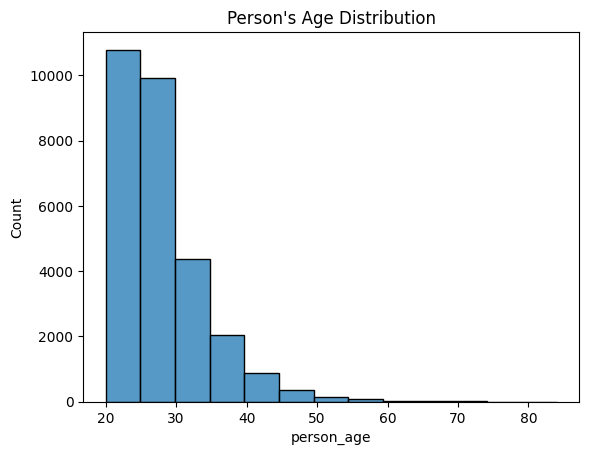

In [15]:
# age distribution
sns.histplot(data=df2, x ='person_age', binwidth=5)
plt.title("Person's Age Distribution")

majority of loan applicants fall within the 20 to 35 age bracket, shedding light on why educational contributions constitute the largest share of loan intents. Next, let's look at the relationship between the loan amount and age.

<Axes: xlabel='person_age', ylabel='loan_amnt'>

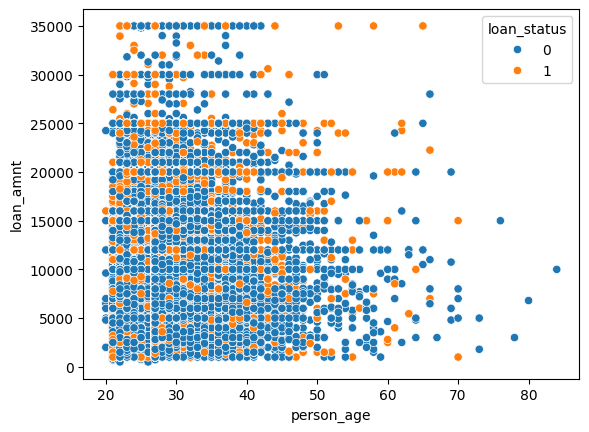

In [16]:
# age vs income
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", hue='loan_status')

There is no significant patterns that explains the relationship between the age and loan amount according to the scatterplot. Similar results were obtained for loand interest rate as well.

<Axes: xlabel='person_age', ylabel='loan_amnt'>

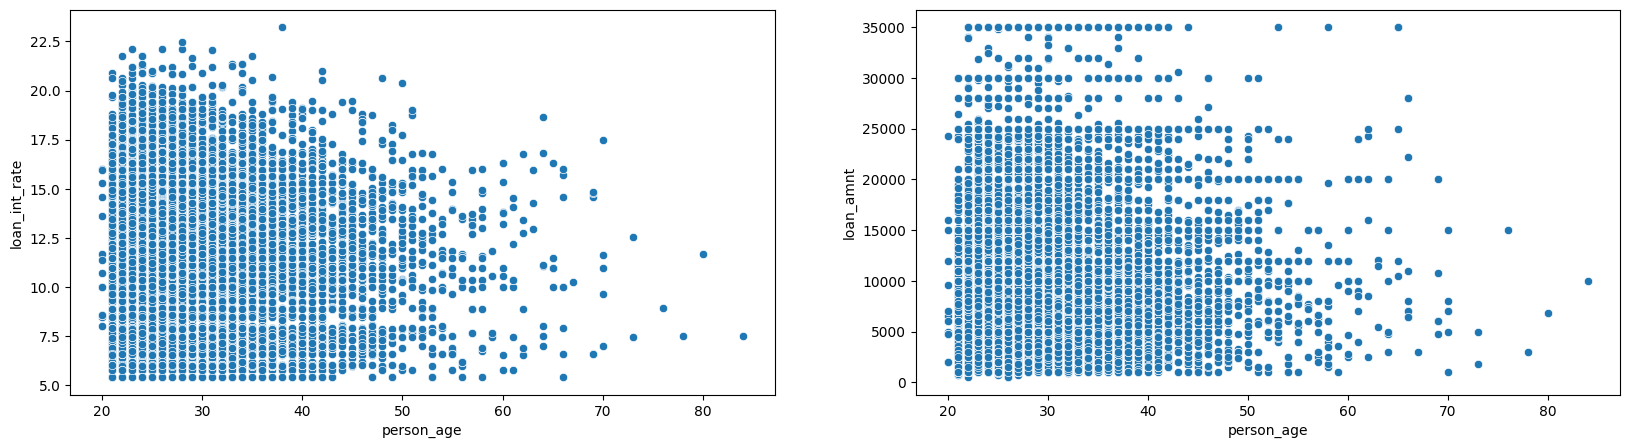

In [17]:
# age vs loan amount and loan rate
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.scatterplot(data=df2, x="person_age", y="loan_int_rate", ax=ax[0])
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", ax=ax[1])

In [18]:
# Convert Yes and No values to 0 and 1
data_df=df2.copy()
data_df['cb_person_default_on_file']=data_df.cb_person_default_on_file.map(dict(Y=1, N=0))

In [19]:
data_df.head(3)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3


Correlation analysis

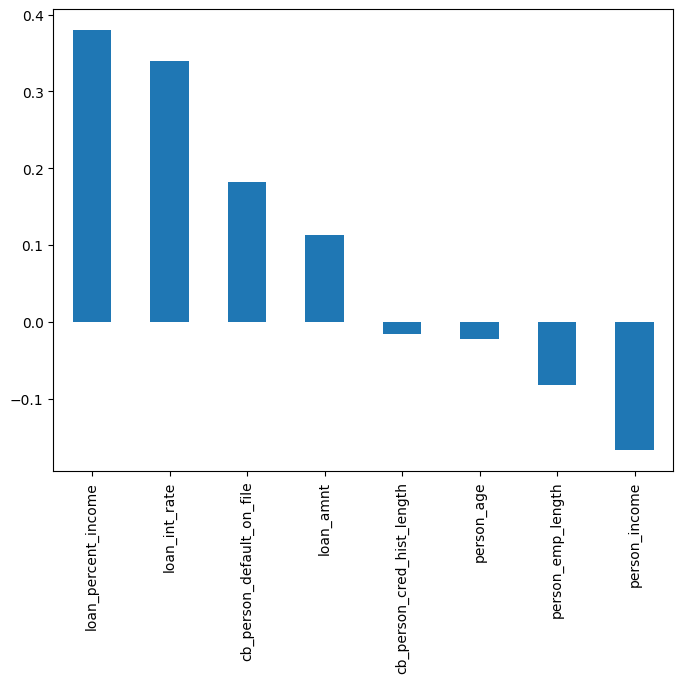

In [20]:
# check correlation between the target and the features
conti_df= data_df.select_dtypes(exclude=[object])

corr_with_tot_count = conti_df.corr()["loan_status"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("loan_status").plot.bar()
plt.show()

The above plot shows that the correlation between the target variable and the loan_percent_income, loan_int_rate, are highly positively correlated and cb_person_cred_hist_length has small correlation with the target. variable.

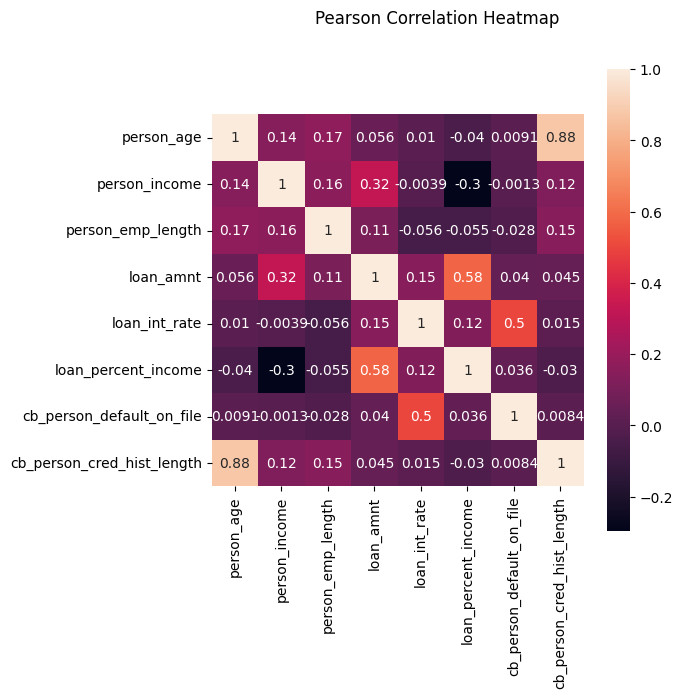

In [21]:
# check for correlation among the features
plt.figure(figsize=(6,6))

sns.heatmap(conti_df.drop(['loan_status'],axis=1).corr(), square=True, annot=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

Person correlation map indicates a high collinearity between the cb_person_cred_hist_length and the person_age. Following the correlation analysis, I am dropping those two features.

In [25]:
# drop a feature
df=data_df.drop(['cb_person_cred_hist_length', 'person_age'],axis=1)

Mutual Information

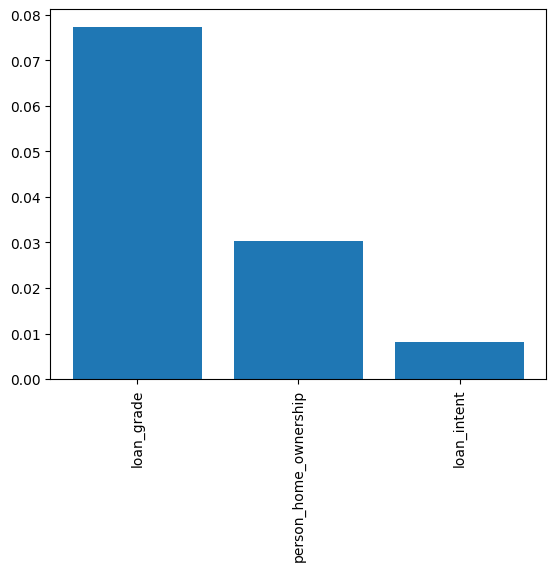

In [26]:
# returns the MI scores
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.loan_status)

# select categorial variables excluding loan status
cat_vars = df.select_dtypes(include=object)

# compute the MI score between each categorical variable and the target
feature_importance_df = cat_vars.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation=90)
plt.show()

In [27]:
feature_importance_df

loan_grade               0.077334
person_home_ownership    0.030432
loan_intent              0.008204
dtype: float64

Based on the MI scores, loan_intent and person_home_ownership shows very low scores and we can drop them for further analysis.

In [28]:
# select the final set of features
selected_features = df.drop(['loan_intent', 'person_home_ownership'], axis=1)

In [29]:
# Label encoding for loan grade
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)

In [29]:
selected_features.head(3)

Model Training

In [30]:
# returns the model performance in terms of accuracy, classification report and the confusion matrix
def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)

In [31]:
# select the features and the target variables
X = selected_features.drop(['loan_status'],axis=1)
y = selected_features['loan_status']

# Train/ Test Split using stratify sampling to solve the class imbalance problem
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

**Logistic Regression**

In [57]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report

# # Assuming X and y are your features and target
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create the logistic regression model
# model_lr = LogisticRegression()

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'penalty': ['l2'],  # Use only 'l2' penalty for lbfgs solver
#     'C': [0.001, 0.01, 0.1, 1, 10]  # Regularization parameter values
# }


# # Instantiate grid search cross-validation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=cv, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get best parameters
# best_params = grid_search.best_params_

# # Instantiate Logistic Regression model with best parameters
# best_model_lr = LogisticRegression(**best_params)

# # Fit the model on training data
# best_model_lr.fit(X_train, y_train)

# # Predictions on test set
# y_pred = best_model_lr.predict(X_test)

# # Model evaluation
# accuracy = accuracy_score(y_test, y_pred)
# cv_accuracy = np.mean(cross_val_score(best_model_lr, X_train, y_train, cv=cv))
# classification_rep = classification_report(y_test, y_pred)

# print("Best Parameters:", best_params)
# print("Accuracy on Test Set:", accuracy)
# print("Cross-Validation Accuracy:", cv_accuracy)
# print("Classification Report:\n", classification_rep)

Best Parameters: {'C': 0.001, 'penalty': 'l2'}
Accuracy on Test Set: 0.8131657063034747
Cross-Validation Accuracy: 0.8048775697829046
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      4514
           1       0.73      0.18      0.30      1213

    accuracy                           0.81      5727
   macro avg       0.78      0.58      0.59      5727
weighted avg       0.80      0.81      0.77      5727



In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l2'],  # Use only 'l2' penalty for lbfgs solver
    'C': [0.001, 0.01, 0.1, 1, 10]  # Regularization parameter values
}

# Instantiate GridSearchCV
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters
best_params_lr = grid_search_lr.best_params_

# Print the best parameters
print("Best Parameters:", best_params_lr)

# Predict using the best model
y_pred_lr = grid_search_lr.predict(X_test)

# Compute accuracy on the test set
accuracy_lr = grid_search_lr.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy_lr)

# Compute cross-validation accuracy
cv_accuracy_lr = np.mean(cross_val_score(grid_search_lr, X_train, y_train, cv=3))
print("Cross-Validation Accuracy:", cv_accuracy_lr)

# Generate classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


Best Parameters: {'C': 0.001, 'penalty': 'l2'}
Accuracy on Test Set: 0.8131657063034747
Cross-Validation Accuracy: 0.8049068287042992
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4514
           1       0.73      0.18      0.30      1213

    accuracy                           0.81      5727
   macro avg       0.78      0.58      0.59      5727
weighted avg       0.80      0.81      0.77      5727



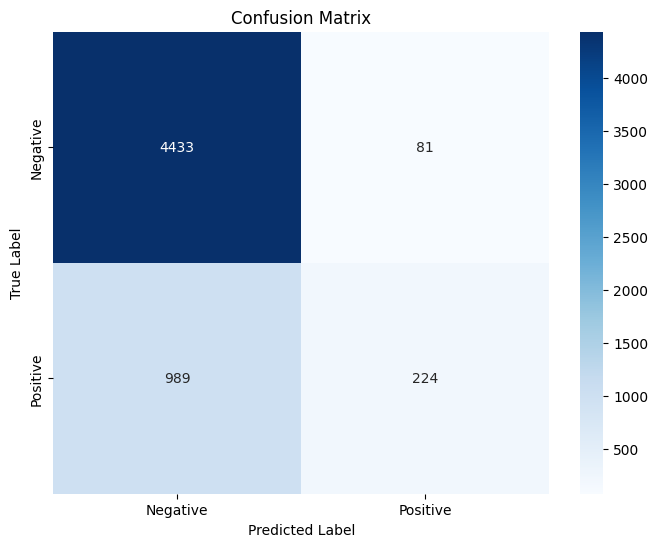

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


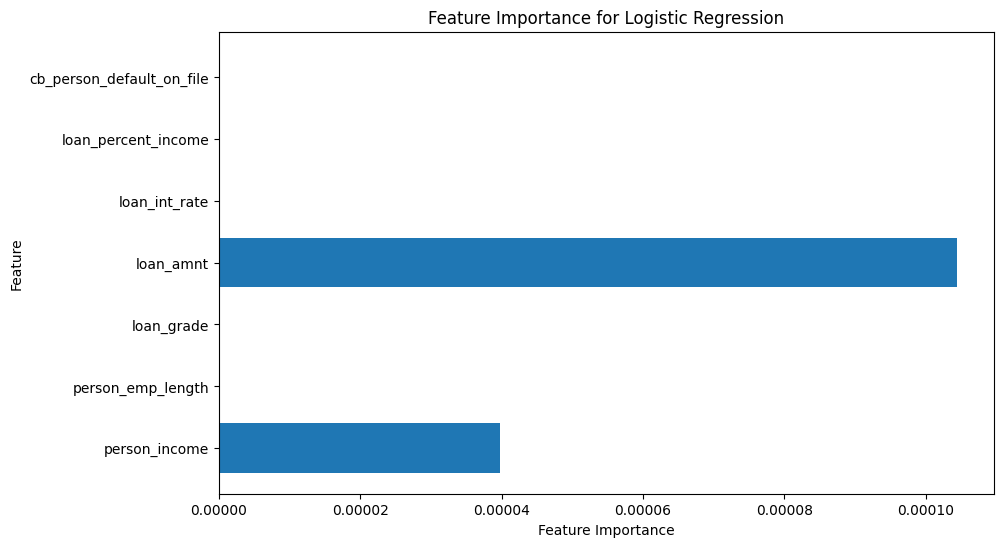

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are your training features and target
# Define and train the Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Calculate feature importance scores (absolute coefficients)
feature_importance = np.abs(model_lr.coef_[0])
feature_names = X.columns.values

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression')
plt.show()


**Random Forest Classifier¶**


Random Forests are an ensemble machine learning algorithm that can be used for both classificaion and regression tasks.

In [32]:
# setting the parameters for the model
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50,max_leaf_nodes = 30)
# fitting the model
model_rf.fit(X_train, y_train)

# make predictions
prediction_test = model_rf.predict(X_test)

Accuracy score of the model 0.8772481229264886
Classification report 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4486
           1       0.76      0.64      0.69      1241

    accuracy                           0.88      5727
   macro avg       0.83      0.79      0.81      5727
weighted avg       0.87      0.88      0.87      5727



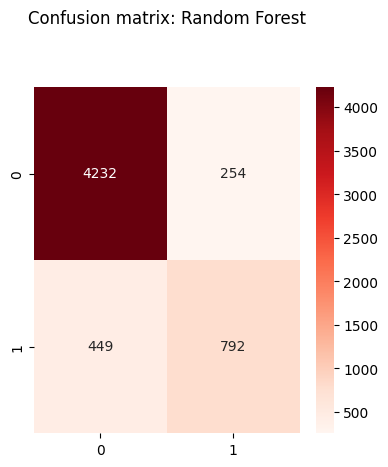

In [33]:
# measure the model performance
model_performance(y_test,prediction_test, 'Random Forest')

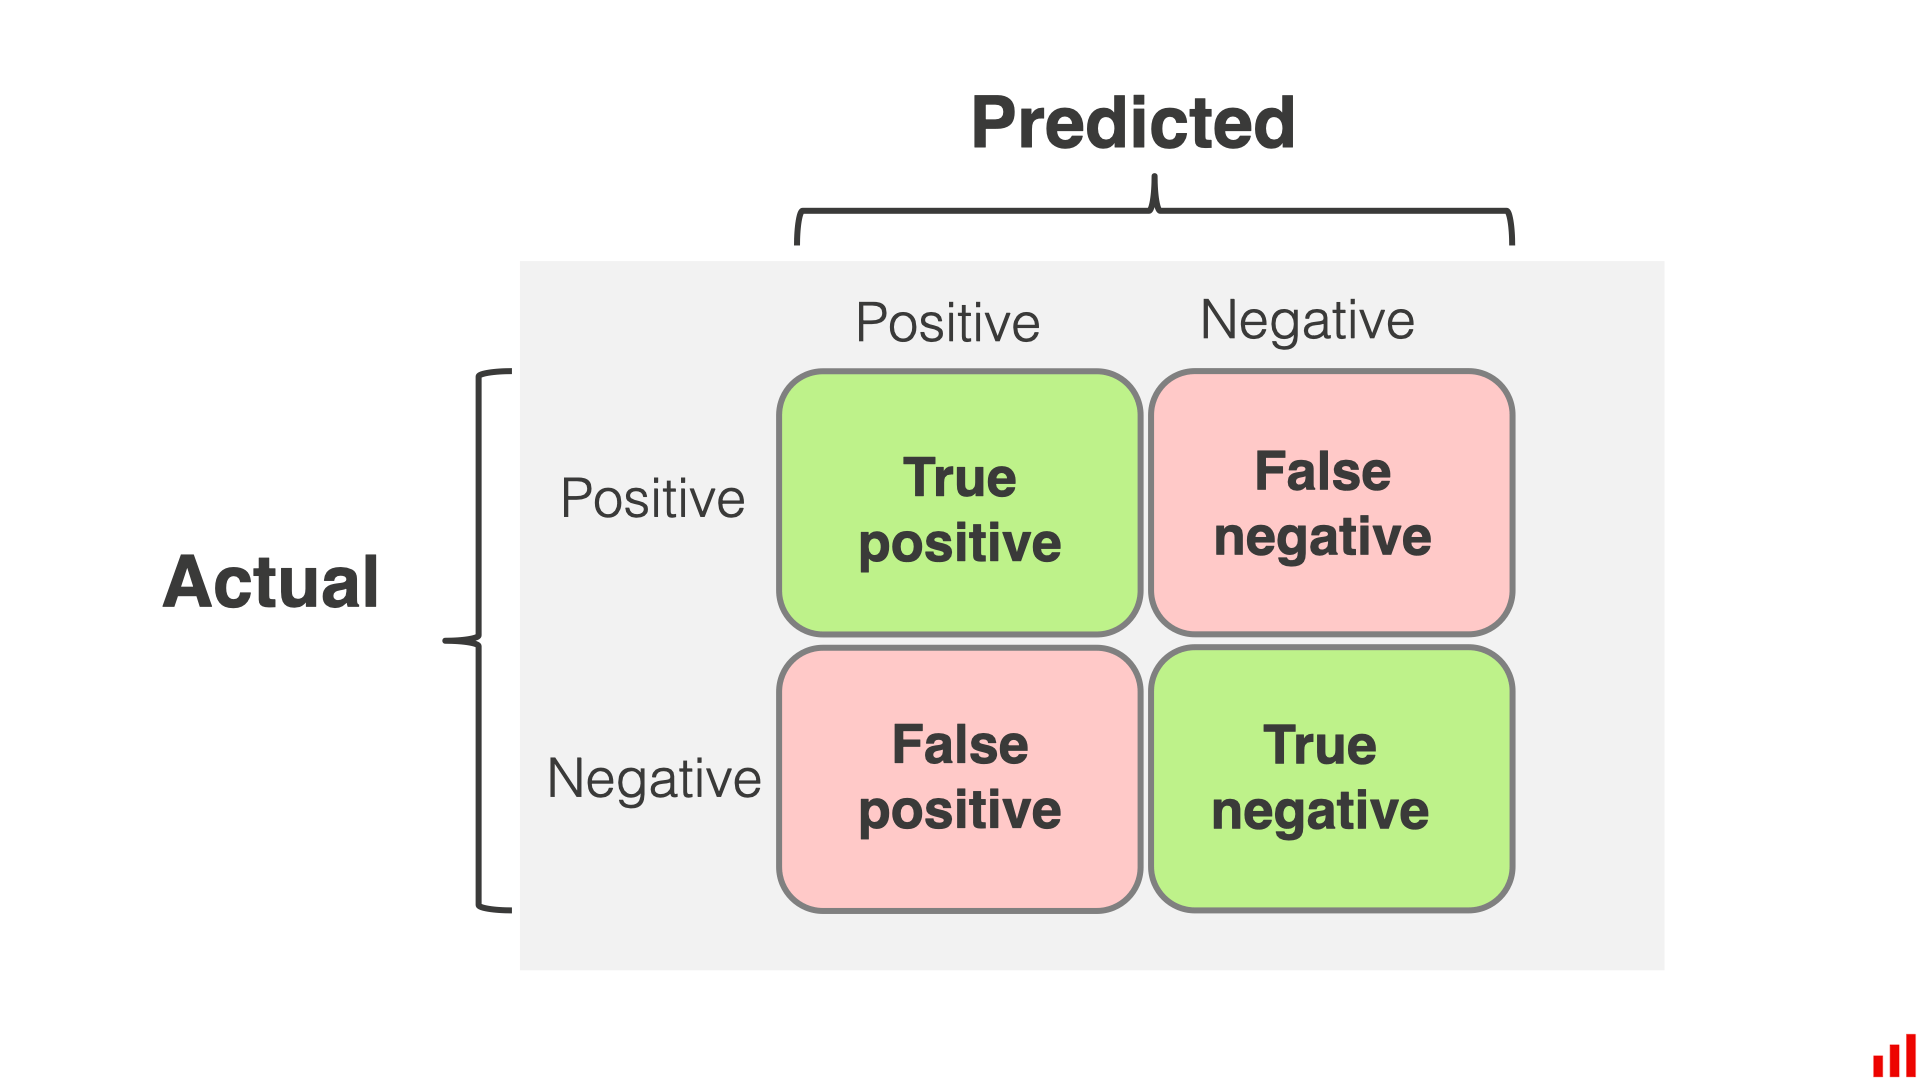

The precision values of 90% and 76% for classes 0 and 1, respectively, signify the model's ability to accurately identify true positive instances within each class. Specifically, for class 0, the model demonstrates high precision (90%), implying that when it predicts a positive instance for this class, it is correct 90% of the time. On the other hand, the lower precision of 76% for class 1 suggests that the model is somewhat less precise in identifying positive instances for this category. The recall values of 94% for class 0 and 64% for class 1 indicate the model's effectiveness in capturing a significant portion of true positive instances for class 0 but a comparatively lower recall for class 1. Overall, the model excels in correctly identifying instances of class 0, but there is room for improvement in its performance for class 1, where it may miss some positive instances. Note that class 0 indicates loan status 0 and class =1 indicates loan status 1.

Cross validation

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold
# apply k-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.872 (0.005)


The accuracy seems pretty consistance with the cross validation results.

**Model tunning**

To optimize the performance of our RandomForest classifier, we can use a grid search approach across its various parameters. By systematically exploring different combinations of hyperparameter values, we can find a configuration that improves the model's predictive capabilities. This process allows us to fine-tune the RandomForest classifier and achieve an optimal balance in parameter settings, ultimately improving its overall accuracy and robustness.

In [35]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'n_estimators': [200, 500],
    'max_leaf_nodes' : [20, 30]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [36]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 500}

Fitting 3 folds for each of 8 candidates, totalling 24 fits

In [37]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 500}

Feature Importance Scores
Random Forests calculate feature importance by evaluating how much each feature contributes to reducing impurity (in classification) or error (in regression) when used as a splitting criterion across the ensemble of decision trees. Features that consistently lead to purer nodes or lower error are considered more important and are used as the basis for feature selection.

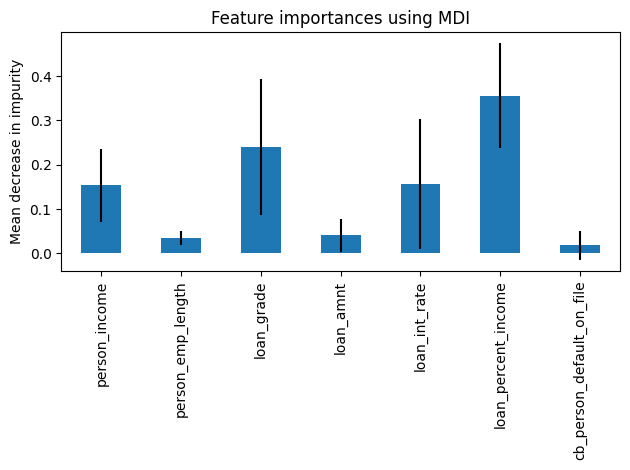

In [38]:
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns.values)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The feature imprtance given by the random forest classifier shows that the most important features are loan_perecent_income, loan_grade, loan_int_rate and person_income.

**XGBoost**

XGBoost, which stands for Extreme Gradient Boosting, is a powerful machine learning algorithm often used for both regression and classification tasks. Rooted in the decision tree methodology, XGBoost's strength lies in its ability to sequentially build a multitude of weak learners, iteratively refining the model's predictive accuracy. In the upcoming analysis, we will assess whether integrating an XGBoost model can yield enhancements over the results obtained from the random forest classifier.

In [39]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
# Convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [41]:
# import XGBClassifier
from xgboost import XGBClassifier

In [42]:
# fit and train the model
model_xgb = XGBClassifier(learning_rate=0.01,
                            n_estimators=50,
                            max_depth=6,
                            random_state=42,
                            n_jobs=-1)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)

Accuracy score of the model 0.8032128514056225
Classification report 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4486
           1       0.97      0.09      0.17      1241

    accuracy                           0.80      5727
   macro avg       0.89      0.55      0.53      5727
weighted avg       0.84      0.80      0.73      5727



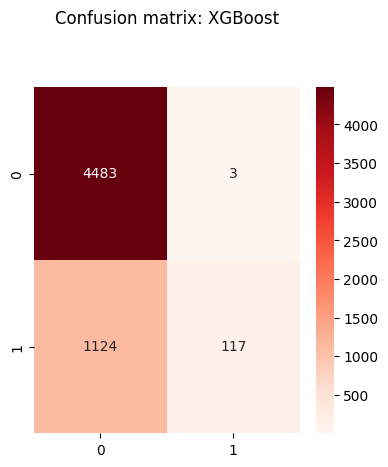

In [43]:
# measure the model performance
model_performance(y_test,y_pred, 'XGBoost')

Precision values of 91% for class 0 and 77% for class 1 indicate the model's ability to accurately identify instances within each class, with a higher precision for class 0. The recall values of 95% for class 0 and 64% for class 1 reflect the model's effectiveness in capturing the majority of true positive instances for class 0, but a relatively lower recall for class 1, suggesting it may miss some positive instances in this category. Overall there is not much improvement over the random forest classifier.

**Model tunning (GridSearch)¶**

Next, we can perform hyperparameter tuning using grid search to determine an optimal set of hyperparameters for our XGBoost model. I have only tried two paramaters here for simplicity. But we can define more and values and other parameters.

In [44]:
# grid search for the XGBClassifier
clf = GridSearchCV(
        model_xgb,
        {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=2,
    )
clf.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8737504967808221
{'max_depth': 6, 'n_estimators': 200}


**K-fold cross validation**

XGBoost supports k-fold cross validation using the cv() method. In tthe following, xgb_cv contains train and test auc metrics for each boosting round.

In [45]:
# define data_dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns.values))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X.columns.values))

In [46]:
from xgboost import cv

# setting the parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# apply cross validation
xgb_cv = cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.624419,0.003112,0.622384,0.006566
1,0.797906,0.003443,0.794819,0.006442
2,0.862019,0.001601,0.859626,0.004062
3,0.870227,0.002174,0.867050,0.004941


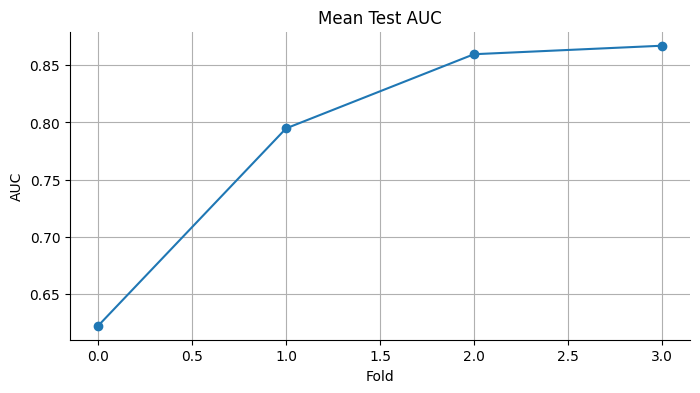

In [65]:
# Plotting the 'test-auc-mean'
plt.figure(figsize=(8, 4))
plt.plot(xgb_cv['test-auc-mean'], marker='o')
plt.title('Mean Test AUC')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

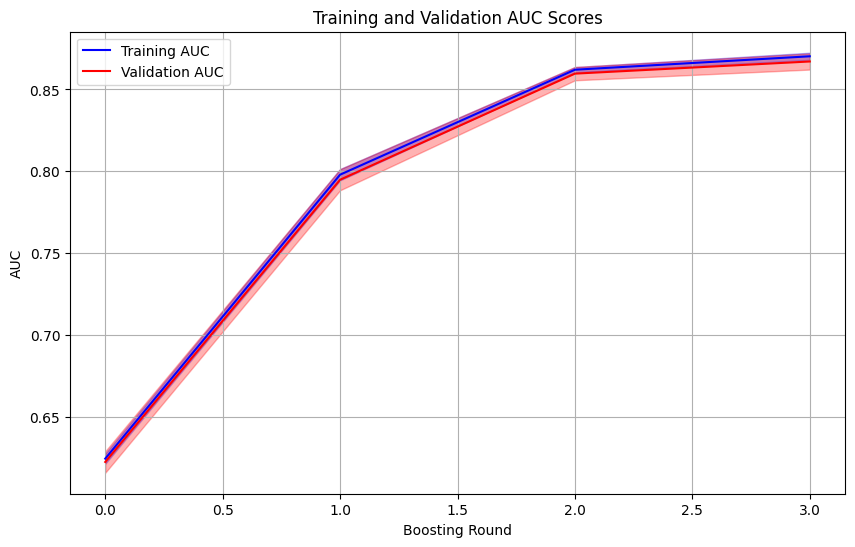

In [66]:
import matplotlib.pyplot as plt

# Plotting AUC scores
plt.figure(figsize=(10, 6))

# Training AUC
plt.plot(xgb_cv['train-auc-mean'], label='Training AUC', color='blue')
plt.fill_between(range(len(xgb_cv)),
                 xgb_cv['train-auc-mean'] - xgb_cv['train-auc-std'],
                 xgb_cv['train-auc-mean'] + xgb_cv['train-auc-std'],
                 alpha=0.3, color='blue')

# Validation AUC
plt.plot(xgb_cv['test-auc-mean'], label='Validation AUC', color='red')
plt.fill_between(range(len(xgb_cv)),
                 xgb_cv['test-auc-mean'] - xgb_cv['test-auc-std'],
                 xgb_cv['test-auc-mean'] + xgb_cv['test-auc-std'],
                 alpha=0.3, color='red')

plt.title('Training and Validation AUC Scores')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# training the model again using the following method to get feature importance with feature names
evals = [(dtrain, 'train'), (dtest, 'validation')]
model_xgb_2 = xgb.train(params, dtrain, num_boost_round=60,
                  early_stopping_rounds=50, maximize=False, evals=evals, verbose_eval=10)

[0]	train-logloss:0.52041	validation-logloss:0.52007
[10]	train-logloss:0.42983	validation-logloss:0.42595
[20]	train-logloss:0.37018	validation-logloss:0.36409
[30]	train-logloss:0.34872	validation-logloss:0.34206
[40]	train-logloss:0.33375	validation-logloss:0.32727
[50]	train-logloss:0.32656	validation-logloss:0.32052
[59]	train-logloss:0.32181	validation-logloss:0.31601


[0]	train-logloss:0.52041	validation-logloss:0.52007
[10]	train-logloss:0.42983	validation-logloss:0.42595
[20]	train-logloss:0.37018	validation-logloss:0.36409
[30]	train-logloss:0.34872	validation-logloss:0.34206
[40]	train-logloss:0.33375	validation-logloss:0.32727
[50]	train-logloss:0.32656	validation-logloss:0.32052
[59]	train-logloss:0.32181	validation-logloss:0.31601


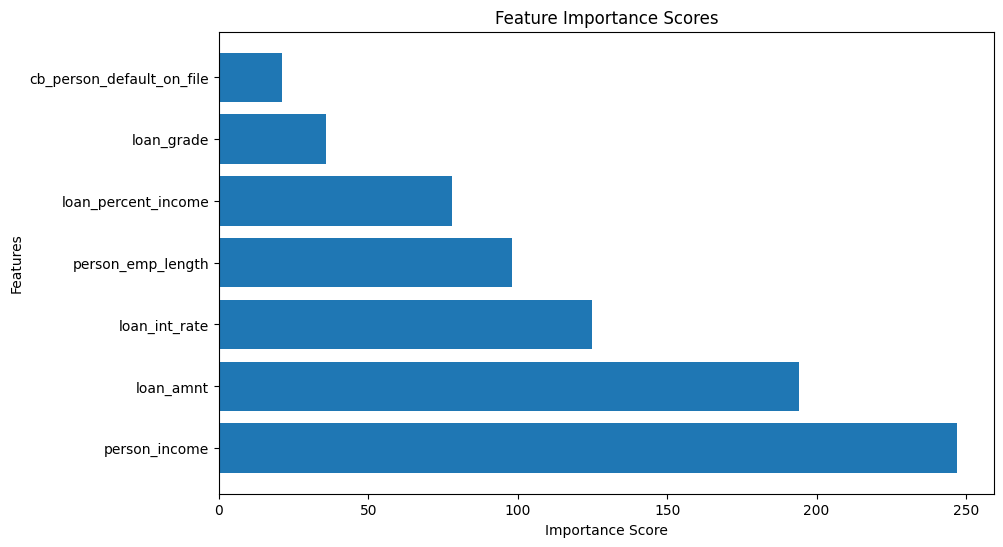

In [67]:
# Train the XGBoost model again with the specified method
evals = [(dtrain, 'train'), (dtest, 'validation')]
model_xgb_2 = xgb.train(params, dtrain, num_boost_round=60,
                        early_stopping_rounds=50, maximize=False,
                        evals=evals, verbose_eval=10)

# Extract feature importance scores with feature names
feature_importance = model_xgb_2.get_fscore()
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*feature_importance)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()


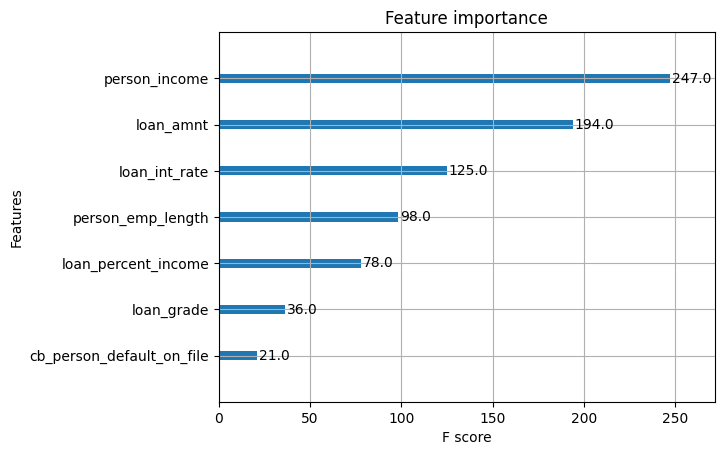

In [48]:
# plot the fearures according to their importance
xgb.plot_importance(model_xgb_2)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

The high feature importance of "person_income" and "loan_int_rate" in the XGBoost model indicates that these variables significantly influence the model's predictions.

**Loan Interest Rate (loan_int_rate):** The interest rate on a loan directly affects the cost of borrowing. A higher interest rate can impact a borrower's ability to repay the loan, potentially increasing the risk of default.

**Person Income (person_income):** The income of the individual is often a crucial determinant in assessing their financial stability and capacity to handle loans. Higher income levels generally correlate with a lower likelihood of defaulting on loans, making it a key feature for predictive models.

**Conclusions:¶**
Comparable Performance: The evaluation of the Random Forest Classifier and XGBoost models reveals similar overall performance in handling the given classification task.
Limited Experimentation and Hyperparameter Tuning: Acknowledging the constraints of the conducted experiments, it's clear that both models have not undergone an all possible space of hyperparameter settings. Further fine-tuning could potentially enhance their predictive capabilities.
Feature Importance Aligns with Financial Principles: The analysis of feature importance in the XGBoost model, especially highlighting "person_income" and "loan_int_rate," aligns well with common financial principles.
Exploring additional hyperparameter combinations, and potentially incorporating more features for a more comprehensive understanding of the underlying data could improve the performance of both models.